#### Resources:
Paul Centore - A Zonohedral Approach to Optimal Colours
(https://legacy.sites.fas.harvard.edu/~cs278/papers/zone.pdf)

#### Instructions:
Make sure to install Jessica's repository as a Python package using the line below. It requires Python 3.11.

In [6]:
!pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

In [1]:
from chromalab.observer import Observer, getsRGBfromWavelength
from chromalab.spectra import Spectra, Illuminant
from colour import XYZ_to_RGB, wavelength_to_XYZ
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
%matplotlib widget

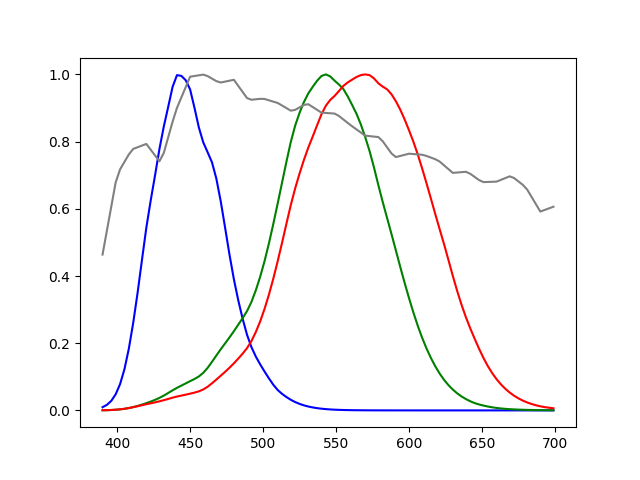

In [2]:
# Cone responses of a typical trichromat.
wavelengths = np.arange(390, 701, 3)
n = len(wavelengths)
standard_trichromat = Observer.trichromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)

standard_trichromat.sensors[0].plot(color="blue")
standard_trichromat.sensors[1].plot(color="green")
standard_trichromat.sensors[2].plot(color="red")
illuminant.plot(color="gray")

plt.show()

In [3]:
# Each point has an indicator reflectance function where R = 1 at a single wavelength and 0 elsewhere.
# These points can be thought of as vectors which form a (linearly dependent) basis.
# The Minkowski sum of these vectors span the object color solid.
# Each point in the solid can be represented as some (non-unique) linear combination of these vectors.
# This represents equations (9), (10), (11), (12), (13).
points = np.vstack((standard_trichromat.sensors[0].data * illuminant.data, 
                    standard_trichromat.sensors[1].data * illuminant.data, 
                    standard_trichromat.sensors[2].data * illuminant.data)).T

# As shown in Centore's paper, these vertices form the shape of the solid.
# This represents the matrix in (7).
vertices = np.zeros((n + 1, n, 3))
for i in range(1, n + 1):
    for j in range(n):
        vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]

# This represents the diagram in (8)
faces = np.zeros((n * (n - 1), 4, 3))
face_colors = np.zeros((n * (n - 1), 3))
for i in tqdm(range(1, n)):
    for j in range(n):
        faces[((i - 1) * n) + j, 0] = vertices[i, j]
        faces[((i - 1) * n) + j, 1] = vertices[i - 1, (j + 1) % n]
        faces[((i - 1) * n) + j, 2] = vertices[i, (j + 1) % n]
        faces[((i - 1) * n) + j, 3] = vertices[i + 1, j]
        
        # Calculate the reflectance on each face by using the reflectance of one of its vertices.
        # Since each vertex can be thought of as a linear combination of the basis vectors, 
        # the vertex's reflectance is the sum of reflectances of those vectors that made up the vertex.
        reflectance_data = np.zeros(n)
        for k in range(i):
            reflectance_data[(j + k) % n] = 1
        reflectance = Spectra(wavelengths=wavelengths, data=reflectance_data)
        face_colors[(i - 1) * n + j] = reflectance.to_rgb(illuminant)    # Bottleneck. Takes about 3ms. 

100%|████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:48<00:00,  2.12it/s]


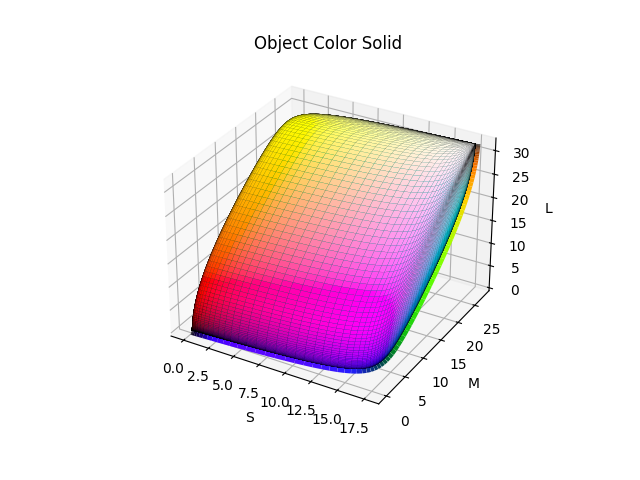

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
poly3d = Poly3DCollection(faces, linewidths=0.05, edgecolors='k')
poly3d.set_facecolor(face_colors)

# Plots the spectral locus, shows the cummulative sum of the vectors that make up the solid.
spectral_locus_start_points = np.vstack(([0, 0, 0], np.cumsum(points, axis=0)[:-1]))
spectral_locus_vectors = points
spectral_locus_colors = np.clip(wavelength_to_XYZ(wavelengths), 0, 1)
for i in range(n):
    ax.quiver(spectral_locus_start_points[i, 0], spectral_locus_start_points[i, 1], spectral_locus_start_points[i, 2],
              spectral_locus_vectors[i, 0], spectral_locus_vectors[i, 1], spectral_locus_vectors[i, 2],
              color=spectral_locus_colors[i], linewidth=7, arrow_length_ratio=0)

ax.add_collection3d(poly3d)
ax.set_xlabel('S')
ax.set_ylabel('M')
ax.set_zlabel('L')
ax.set_title('Object Color Solid')
plt.show()